In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Plots
using Test
include("car.jl");
using ForwardDiff

  Activating environment at `~/ocrl_ws/project/ocrl_project/Project.toml`
  Activating environment at `~/ocrl_ws/project/ocrl_project/Project.toml`


In [2]:
# Define the model
model = BicycleModel()

# get the number of states and controls
n = state_dim(model)
m = control_dim(model)

# Evaluate the continuous and discrete dynamics
x0 = SA[0.,0.,0.,0.]
u0 = SA[0.,0.]
t0 = 0.0
dt = 0.025
dynamics(model, x0, u0)
discrete_dynamics(RK4, model, x0, u0, t0, dt)  # use rk4 for integration

# Evaluate the continuous and discrete Jacobians
z0 = KnotPoint(x0,u0,dt,t0)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, z0)
discrete_jacobian!(RK4, ∇f, model, z0)

# Extract pieces of the Jacobian
A = ∇f.A
B = ∇f.B;

In [136]:
nx = n
nu = m

Q = Diagonal([1,1,1e-2,1e-2])
R = Diagonal([1e-1,1e-1])
Qf = Diagonal([1,1,1,1.])*10

bots = 5
N = 101 #401
Nmpc = 10 #60
Nhz = 1
delta = 12 #80
Nc = N + (bots)*delta

FD = ForwardDiff;

In [137]:
function get_path()
    x1ref = zeros(Nc)*NaN
    x2ref = zeros(Nc)*NaN
    θref = zeros(Nc)*NaN
    v1ref = zeros(Nc)*NaN
    v2ref = zeros(Nc)*NaN
    ωref = zeros(Nc)*NaN
    rad = 20
    
    u1ref = zeros(Nc-1)*NaN
    u2ref = zeros(Nc-1)*NaN
    
    for i = 1:Nc
        θref[i] = 2*pi*(i-Nc)/(Nc-1)
        x1ref[i] = rad * sin(θref[i])
        x2ref[i] = rad - rad * cos(θref[i])
    end
    
    for i = 1:Nc-1
        v1ref[i] = 0.0
        u1ref[i] = sqrt((x1ref[i+1] - x1ref[i])^2 + (x2ref[i+1] - x2ref[i])^2)/dt
        u2ref[i] = 0.0
    end
    v1ref[1] = 0.0
    v1ref[Nc] = v1ref[Nc-1]
#     u1ref[Nc] = u1ref[Nc-1]
    
    xref = [x1ref'; x2ref'; θref'; v1ref']
    uref = [u1ref'; u2ref']
    return [x for x in eachcol(xref)], [u for u in eachcol(uref)]
end

get_path (generic function with 1 method)

In [138]:
# Plot the reference trajectory and compare with the given plot
Xref, Uref = get_path()

# convert to static arrays and plot
Xref = [SVector{4}(Xref[i]) for i = 1:length(Xref)]
tref = SA[0:dt:(Nc-1-2*delta)*dt]
trefu = SA[0:dt:(Nc-2-2*delta)*dt]

Uref = [SVector{2}(Uref[i]) for i = 1:length(Uref)];

## The Reference Trajectory
In this problem we'll be tracking a reference trajectory generated via trajectory optimization. The code below loads the reference trajectory, plots it using `Plots.jl` (and some custom plotting recipes in `RobotDynamics`) and visualizes it using MeshCat.

In [139]:
Q = Diagonal([10,10,10,1.])
R = Diagonal([1.,1.])
Qf = Diagonal([1,1,1,1.])*1;

In [140]:
function stage_cost(x,u,xref,uref, Q, R, Qf)
    # LQR cost at each knot point (depends on both x and u)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x,xref, Q, R, Qf)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:Nmpc-1
        J += stage_cost(X[i],U[i],Xref[i],Uref[i], Q, R, Qf)
    end
    J += term_cost(X[end], Xref[end], Q, R, Qf)
    
    return J
end
        
function stage_cost_expansion(x,u,xref,uref, Q, R, Qf, Nmpc)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = Q
    Jx = Q * (x - xref)
    Juu = R
    Ju = R * (u - uref)
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref, Q, R, Qf, Nmpc)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    Jxx = Qf
    Jx = Qf * (x - xref)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [141]:
function stage_cost_convoy(x, xref, Q)
    # LQR cost at each knot point (depends on both x and u)
    J = 0.5 * (x - xref)' * Q * (x - xref)
    
    return J
end

function trajectory_cost_convoy(X, Xref, Q, Nmpc)
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:Nmpc
        J += stage_cost_convoy(X[i], Xref[i], Q)
    end
    
    return J
end
        
function stage_cost_expansion_convoy(x, xref, Q, Nmpc)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = Q
    Jx = Q * (x - xref)
    
    return Jxx, Jx
end

function total_cost(X,U,Xref,Uref,Xfoll,Xlead, K,d,ΔJ, Q, R, Qf, Qfoll, Qlead, Nmpc)
    J_traj = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    J_foll = trajectory_cost_convoy(X, Xfoll, Qfoll, Nmpc)
    J_lead = trajectory_cost_convoy(X, Xlead, Qlead, Nmpc)
    return J_traj + J_foll + J_lead
end

total_cost (generic function with 1 method)

In [142]:
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> discrete_dynamics(RK4, model, _x, u, t0, dt),x)
    B = FD.jacobian(_u -> discrete_dynamics(RK4, model, x, _u, t0, dt),u)
    return A,B
end

dynamics_jacobians (generic function with 1 method)

In [143]:
function backward_pass(X,U,Xref,Uref,Xfoll,Xlead, Q, R, Qf, Qfoll, Qlead, Nmpc)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:Nmpc]     # cost to go quadratic term
    p = [zeros(nx) for i = 1:Nmpc]        # cost to go linear term 
    d = [zeros(nu)*NaN for i = 1:Nmpc-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:Nmpc-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    P[Nmpc], p[Nmpc] = term_cost_expansion(X[Nmpc],Xref[Nmpc], Q, R, Qf, Nmpc)
    for i in reverse(1:Nmpc-1)
        A, B = dynamics_jacobians(X[i],U[i],dt)
        lxx, lx, luu, lu = stage_cost_expansion(X[i],U[i],Xref[i],Uref[i], Q, R, Qf, Nmpc)
        lxx_foll, lx_foll = stage_cost_expansion_convoy(X[i], Xfoll[i], Qfoll, Nmpc)
        lxx_lead, lx_lead = stage_cost_expansion_convoy(X[i], Xlead[i], Qlead, Nmpc)
        lxx += lxx_foll + lxx_lead
        lx += lx_foll + lx_lead
        gx = lx + A'*p[i+1]
        gu = lu + B'*p[i+1]
        Gxx = lxx + A'*P[i+1]*A
        Guu = luu + B'*P[i+1]*B
        Gxu = A'*P[i+1]*B
        Gux = B'*P[i+1]*A
        d[i] = inv(Guu)*gu
        K[i] = inv(Guu)*Gux
        P[i] = Gxx + K[i]'*Guu*K[i] - Gxu*K[i] - K[i]'*Gux
        p[i] = gx - K[i]'*gu + K[i]'Guu*d[i] - Gxu*d[i]
        ΔJ += gu'*d[i]
    end
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [144]:
function forward_pass(X,U,Xref,Uref,Xfoll,Xlead, K,d,ΔJ, Q, R, Qf, Qfoll, Qlead, Nmpc; max_iters = 100)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    Jn = trajectory_cost(Xn,Un,Xref,Uref, Q, R, Qf, Nmpc)
    J = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    α = 2
    iters = 0
    
    while Jn >= J - 0.002*α*ΔJ && iters < max_iters
        α *= 0.5
        Xn = deepcopy(X)
        Un = deepcopy(U)
        for i = 1:Nmpc-1
            Un[i] = U[i] - α*d[i] - K[i]*(Xn[i]-X[i])
            Xn[i+1] = discrete_dynamics(RK4, model, Xn[i], Un[i], t0, dt)
        end
        J = total_cost(X,U,Xref,Uref,Xfoll,Xlead, K,d,ΔJ, Q, R, Qf, Qfoll, Qlead, Nmpc)
        Jn = total_cost(Xn,Un,Xref,Uref,Xfoll,Xlead, K,d,ΔJ, Q, R, Qf, Qfoll, Qlead, Nmpc)
        iters += 1
    end
        
    return Xn, Un, Jn, α
end

forward_pass (generic function with 1 method)

In [145]:
function iLQR(x0,U,Xref,Uref,Xfoll,Xlead, Q, R, Qf, Qfoll, Qlead, Nmpc;atol=10,max_iters = 40,verbose = true)
    X = [x0 for i = 1:Nmpc]
    U = U
    K = [zeros(nu,nx)*NaN for i = 1:Nmpc-1]
    P = [zeros(nx,nx)*NaN for i = 1:Nmpc]
    iter = -1
    max_norm = 10000
    
    while(iter < max_iters && max_norm > atol)
        d, K, P, ΔJ = backward_pass(X,U,Xref,Uref,Xfoll,Xlead, Q, R, Qf, Qfoll, Qlead, Nmpc)
        X, U, Jr, α = forward_pass(X,U,Xref,Uref,Xfoll,Xlead, K,d,ΔJ, Q, R, Qf, Qfoll, Qlead, Nmpc)
        iter += 1
        max_norm = max(norm(d))
    end

    return X,U,K,P,iter

end

iLQR (generic function with 1 method)

In [146]:
function get_closest_index(x, Xref)
    min_val = 99999999
    min_idx = 100
    for i = 1:length(Xref)
        x2 = Xref[i]
        dist = sqrt((x[1]-x2[1])^2 + (x[2]-x2[2])^2 + 10*(x[3]-x2[3])^2)
        if dist < min_val
            min_val = dist
            min_idx = i
        end
    end
    return min_idx
end

function getXUmpc(x, u, Xref, Uref, i, Nhz, Nmpc, Nc)
    k = get_closest_index(x, Xref)
    Xrefmpc = [SVector{4}(Xref[j]) for j = k:min(Nmpc+k, Nc)]
    Urefmpc = [SVector{2}(Uref[j]) for j = k:min(Nmpc+k, Nc)-1]
    U0ref = [SVector{2}(u) for j = k:Nmpc+k-1]
    append!(Urefmpc, [SVector{2}([0., 0.]) for j = min(Nmpc, Nc-k):Nmpc-1])
    append!(Xrefmpc, [SVector{4}(Xref[end]) for j = min(Nmpc, Nc-k):Nmpc])
    Xrefmpc[1] = x
    Urefmpc[1] = u
   
    return Xrefmpc, Urefmpc, U0ref
end

function getFollowerX(XLast, Xcurr, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(min(get_closest_index(XLast, Xref) + gap_idx, Nc))
    return [SVector{4}(Xref[idx] *(j-1)/(Nmpc+1) + Xcurr *(1 - (j-1)/(Nmpc+1))) for j = 1:Nmpc+2]
end

function getLeaderX(XLast, Xcurr, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(max(get_closest_index(XLast, Xref) - gap_idx, 1))
    return [SVector{4}(Xref[idx] *(j-1)/(Nmpc+1) + Xcurr *(1 - (j-1)/(Nmpc+1))) for j = 1:Nmpc+2]
end

function getFollowerX(XLast, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(min(get_closest_index(XLast, Xref) + gap_idx, Nc))
    return [SVector{4}(Xref[idx]) for j = 1:Nmpc+2]
end

function getLeaderX(XLast, Xref, gap_idx, Nmpc, Nc)
    idx = Int64(max(get_closest_index(XLast, Xref) - gap_idx, 1))
    return [SVector{4}(Xref[idx]) for j = 1:Nmpc+2]
end

function getDist(x, xn)
    x1 = x[1]
    y1 = x[2]
    x2 = xn[1]
    y2 = xn[2]
    return (x1-x2)^2 + (y1-y2)^2
end

function getWeightMultiplier(dist, des_dist)
    mult = 1
    if dist > des_dist
        mult = 1 + 0.1 * (dist - des_dist) / dist^2
    else
        mult = 1 + 1 * (des_dist - dist) / sqrt(dist)
    end
    return mult
end

getWeightMultiplier (generic function with 1 method)

In [461]:
function ilqr_mpc_multi(Xref, Uref, start, Q, R, Qf, Qfoll, Qlead, Nhz, Nmpc, Nc, delta, bots, pred_flag)
    wt_f = 10      # Weight for robot that is following
    wt_f1 = 15     # Weight for robot that is following the first robot
    wt_l = 10      # Weight for robot that is leading
    wt_ll = 15     # Weight for robot that is leading the last robot
    wt_traj = 10   # Weight to follow the provided trajectory
    wt_traj1 = 10  # Weight to follow the provided trajectory for the lead robot
    
    XLast = [SVector{4}(Xref[start+(bots-(k))*delta]) for k=1:bots]
    ULast = [SVector{2}(Uref[start+(bots-(k))*delta]) for k=1:bots]
    XLast1 = [SVector{4}(Xref[start+(bots-(k))*delta]) for k=1:bots]
    ULast1 = [SVector{2}(Uref[start+(bots-(k))*delta]) for k=1:bots]
    Xline = [copy(Xref) for k=1:bots]
    Uline = [copy(Uref) for k=1:bots]
    Xfol = [copy(Xref) for k=1:bots]
    Xlead = [copy(Xref) for k=1:bots]
    Xtraj = [copy(Xref) for k=1:bots]
    Xconvoy = [copy(Xref) for k=1:bots]
    gap_idx = Int64(delta/3)
    gap_dist = getDist(Xref[1], Xref[gap_idx+1])
    for i = start:Nhz:Nc-1
        
        for k = 1:bots
            Xrefmpc, Urefmpc, U0ref = getXUmpc(XLast[k], ULast[k], Xref, Uref, i+(k-1)*delta, Nhz, Nmpc, Nc)  
            Q_foll = deepcopy(Qfoll)
            Q_lead = deepcopy(Qlead)
            Q_traj = deepcopy(Q)
            
            wt_f = 10      # Weight for robot that is following
            wt_f1 = 15     # Weight for robot that is following the first robot
            wt_l = 10      # Weight for robot that is leading
            wt_ll = 15     # Weight for robot that is leading the last robot
            wt_traj = 0   # Weight to follow the provided trajectory
            wt_traj1 = 10  # Weight to follow the provided trajectory for the lead robot
            
            if k == 1
                if pred_flag == true
                    Xf = getFollowerX(XLast[k+1], XLast[k], Xref, gap_idx, Nmpc, Nc)
                else
                    Xf = getFollowerX(XLast[k+1], Xref, gap_idx, Nmpc, Nc)
                end
                cur_dist_f = getDist(XLast[k], XLast[k+1])
                wt_f1 *= getWeightMultiplier(cur_dist_f, gap_dist)
                Q_lead = Diagonal([0.,0.,0.,0.])
                Q_foll = Q_foll * wt_f1
                Q_traj = Q_traj * wt_traj1
                Xl = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                
                Xrefc = (wt_traj1*Xrefmpc + wt_f1*Xf) / (wt_traj1+wt_f1)
                Xfol[k][i:i+Nhz-1] = Xf[1:Nhz]
            elseif k == bots
                if pred_flag == true
                    Xl = getLeaderX(XLast[k-1], XLast[k], Xref, gap_idx, Nmpc, Nc)
                else
                    Xl = getLeaderX(XLast[k-1], Xref, gap_idx, Nmpc, Nc)
                end
                cur_dist_l = getDist(XLast[k], XLast[k-1])
                wt_ll *= getWeightMultiplier(cur_dist_l, gap_dist)
                Q_foll = Diagonal([0.,0.,0.,0.])
                Q_lead = Q_lead * wt_ll
                Q_traj = Q_traj * wt_traj
                Xf = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                Xrefc = (wt_traj*Xrefmpc + wt_ll*Xl) / (wt_traj+wt_ll)
                
                Xlead[k][i:i+Nhz-1] = Xl[1:Nhz]
                
            # Code to stop 3rd robot at half time
            elseif k == 3 && i > Nc/2
                Xrefmpc = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                Xrefc = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                Urefmpc = [SVector{2}([0., 0.]) for j = 1:Nmpc+2]
                Q_foll = Diagonal([0.,0.,0.,0.])
                Xf = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                Q_lead = Diagonal([0.,0.,0.,0.])
                Xl = [SVector{4}(XLast[k]) for j = 1:Nmpc+2]
                Q_traj = Q_traj * wt_traj
                
            else
                if pred_flag == true
                    Xf = getFollowerX(XLast[k+1], XLast[k], Xref, gap_idx, Nmpc, Nc)
                    Xl = getLeaderX(XLast[k-1], XLast[k], Xref, gap_idx, Nmpc, Nc)
                else
                    Xf = getFollowerX(XLast[k+1], Xref, gap_idx, Nmpc, Nc)
                    Xl = getLeaderX(XLast[k-1], Xref, gap_idx, Nmpc, Nc)
                end
                cur_dist_f = getDist(XLast[k], XLast[k+1])
                cur_dist_l = getDist(XLast[k], XLast[k-1])
                wt_f *= getWeightMultiplier(cur_dist_f, gap_dist)
                wt_l *= getWeightMultiplier(cur_dist_l, gap_dist)
                Q_foll = Q_foll * wt_f
                Q_lead = Q_lead * wt_l
                Q_traj = Q_traj * wt_traj
                Xrefc = (wt_traj*Xrefmpc + wt_f*Xf + wt_l*Xl) / (wt_traj+wt_f+wt_l)
                
                Xfol[k][i:i+Nhz-1] = Xf[1:Nhz]
                Xlead[k][i:i+Nhz-1] = Xl[1:Nhz]
            end
            
            Xmpc,Umpc,Kmpc,Pmpc,itmpc = iLQR(Xrefmpc[1],U0ref,Xrefmpc,Urefmpc,Xf,Xl, Q_traj, R, Qf, Q_foll, Q_lead, Nmpc)
            Xline[k][i:i+Nhz-1] = Xmpc[1:Nhz]
            Uline[k][i:i+Nhz-1] = Umpc[1:Nhz]
            Xconvoy[k][i:i+Nhz-1] = Xrefc[1:Nhz]
            Xtraj[k][i:i+Nhz-1] = Xrefmpc[1:Nhz]
            XLast1[k] = Xmpc[Nhz+1]
            ULast1[k] = Umpc[Nhz+1]
        end
        
        XLast = XLast1
        ULast = ULast1
        
    end
    return Xline, Uline, Xfol, Xlead, Xtraj, Xconvoy
end

ilqr_mpc_multi (generic function with 1 method)

In [462]:
Q = Diagonal([1,1,100,0.])
R = Diagonal([1.,10.])
Qf = Diagonal([1,1,1,1.])*1
Qfoll = Diagonal([1,1,100,0.])*1
Qlead = Diagonal([1,1,100,0.])*1
bots = 5
start = 1
init_delta = 12
pred_flag = false;

In [463]:
Xlinec, Ulinec, Xfol, Xlead, Xtraj, Xconvoy = 
ilqr_mpc_multi(Xref, Uref, start, Q, R, Qf, Qfoll, Qlead, Nhz, Nmpc, Nc, init_delta, bots, pred_flag);

In [464]:
for k = 1:bots
    Xlinec[k] = [SVector{4}(Xlinec[k][i]) for i = 1:length(Xlinec[k])-1]
    Ulinec[k] = [SVector{2}(Ulinec[k][i]) for i = 1:length(Ulinec[k])-1]
    Xfol[k] = [SVector{4}(Xfol[k][i]) for i = 1:length(Xfol[k])-1]
    Xlead[k] = [SVector{4}(Xlead[k][i]) for i = 1:length(Xlead[k])-1]
    Xtraj[k] = [SVector{4}(Xtraj[k][i]) for i = 1:length(Xtraj[k])-1]
    Xconvoy[k] = [SVector{4}(Xconvoy[k][i]) for i = 1:length(Xconvoy[k])-1]
end

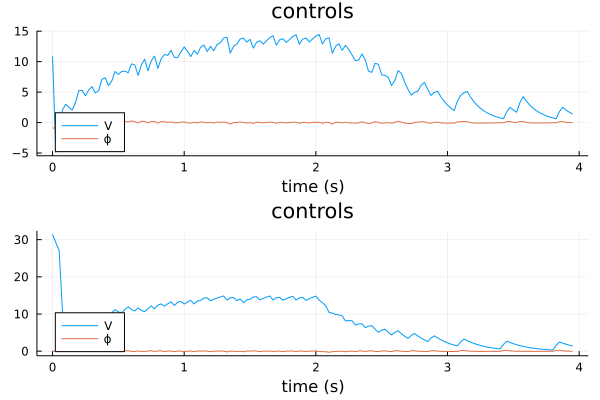

In [465]:
trefU = SA[0:dt:(Nc-2-1)*dt]
p = plot(layout=(2,1))
plot!(p[1], trefU, Ulinec[1], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[2], trefU, Ulinec[2], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
# plot!(p[3], trefU, Ulinec[3], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
# plot!(p[4], trefU, Ulinec[4], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
# plot!(p[5], trefU, Ulinec[5], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")

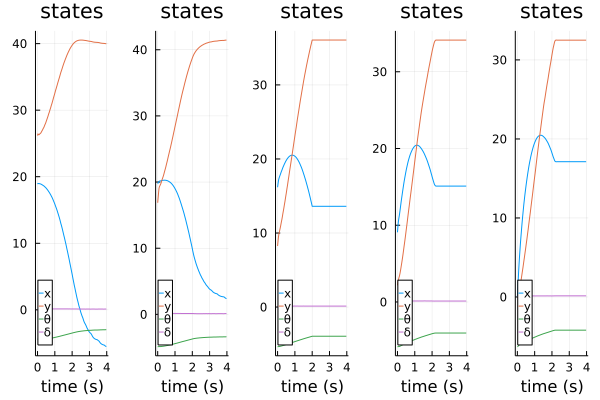

In [466]:
trefN = SA[0:dt:(Nc-1-1)*dt]
p = plot(layout=(1, bots))
plot!(p[1], trefN, Xlinec[1], inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[2], trefN, Xlinec[2], inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[3], trefN, Xlinec[3], inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[4], trefN, Xlinec[4], inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[5], trefN, Xlinec[5], inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")

┌ Info: Saved animation to 
│   fn = /home/nambags/ocrl_ws/project/ocrl_project/src/tmp.gif
└ @ Plots /home/nambags/.julia/packages/Plots/8K4be/src/animation.jl:114


Plots.AnimatedGif("/home/nambags/ocrl_ws/project/ocrl_project/src/tmp.gif")
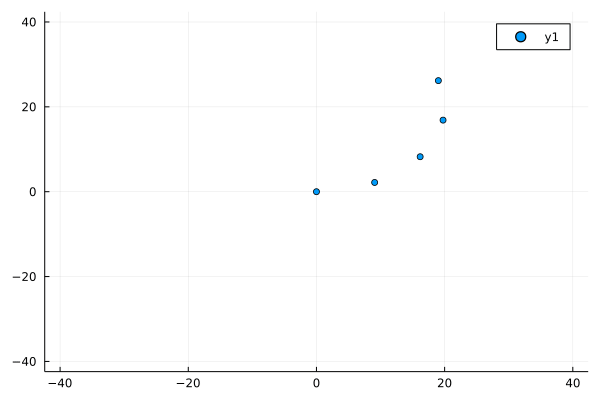

In [467]:
@gif for i = 1:Nc-1-1
    scatter([Xlinec[1][i][1], Xlinec[2][i][1], Xlinec[3][i][1], Xlinec[4][i][1], Xlinec[5][i][1]], 
        [Xlinec[1][i][2], Xlinec[2][i][2], Xlinec[3][i][2], Xlinec[4][i][2], Xlinec[5][i][2]], 
        xlim=[-40, 40], ylim=[-40,40])
end

In [34]:
function diff_dist(Xline1, Xline2, Xref)
    len_dist = length(Xline1)
    dist = zeros(len_dist)*NaN
    for i = 1:length(Xline1)
        idx1 = get_closest_index(Xline1[i], Xref)
        idx2 = get_closest_index(Xline2[i], Xref)
        dist[i] = idx2 - idx1
    end
    return dist
end

diff_dist (generic function with 1 method)

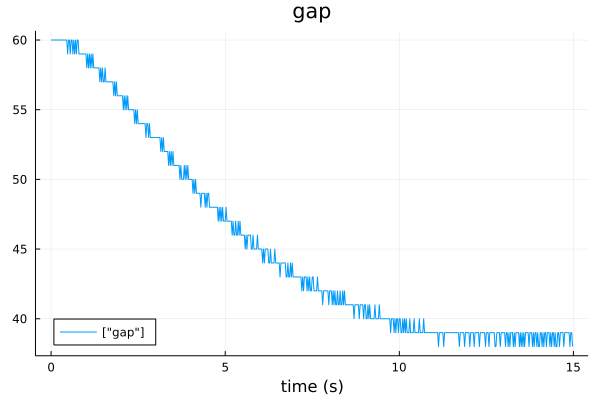

In [21]:
XDiff = diff_dist(Xlinec[3], Xlinec[2], Xref)
XDiff = [SVector{1}(XDiff[i]) for i = 1:length(XDiff)]
p = plot(layout=(1,1))
plot!(p[1], trefN, XDiff, labels=["gap"], legend=:bottomleft, title="gap", xlabel="time (s)")

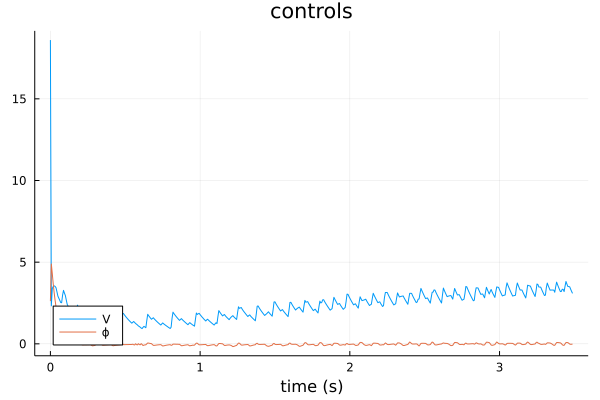

In [48]:
plot(trefU, Ulinec[2], inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")

In [17]:
Xline, Uline = ilqr_mpc(Xref, Uref, 1, Q, R, Qf, Nhz, Nmpc, Nc);

In [18]:
Xline = [SVector{4}(Xline[i]) for i = 1:length(Xline)]
Uline = [SVector{2}(Uline[i]) for i = 1:length(Uline)];

In [42]:
savefig("/home/nambags/convoy_ws/rough")

In [21]:
outfile = "convoy5.txt"
f = open(outfile, "w")

for i = 1:length(Xlinec)
    println(f, Xlinec[i])
end

In [28]:
outfile = "base_ilqr5.txt"
f = open(outfile, "w")

for i = 1:length(Xlinec)
    println(f, Xlinec[i])
end

In [29]:
@show Xlinec[5]

Xlinec[5] = SVector{4, Float64}[[14.862896509547891, 6.617387872822844, -5.445427266222308, 0.0], [15.003674635549968, 6.774901852293426, -5.444931277862312, 0.01267794117033391], [15.143356671174377, 6.933678273330796, -5.443467664091211, 0.02469293017955658], [15.281832879716424, 7.093780487291751, -5.441086633577602, 0.03603710193322828], [15.418995520977882, 7.255256609596474, -5.437839101603263, 0.04670841956010095], [15.554739961647106, 7.41814114685194, -5.433776345898668, 0.056710385178151586], [15.688965704073443, 7.582456670137153, -5.428949633918964, 0.0660516136828153], [15.821577273493933, 7.748215467803795, -5.423409841049996, 0.07474531312900179], [15.952484926429351, 7.915421125756507, -5.417207077182293, 0.08280870789866442], [16.08160516286027, 8.084069996824082, -5.410390336286889, 0.09026243423756035], [16.20886104115656, 8.254152533186327, -5.403007180402821, 0.09712993188880487], [16.335309814528355, 8.42803973233768, -5.3946945988924355, 0.11123688912129505], [16

600-element Vector{SVector{4, Float64}}:
 [14.862896509547891, 6.617387872822844, -5.445427266222308, 0.0]
 [15.003674635549968, 6.774901852293426, -5.444931277862312, 0.01267794117033391]
 [15.143356671174377, 6.933678273330796, -5.443467664091211, 0.02469293017955658]
 [15.281832879716424, 7.093780487291751, -5.441086633577602, 0.03603710193322828]
 [15.418995520977882, 7.255256609596474, -5.437839101603263, 0.04670841956010095]
 [15.554739961647106, 7.41814114685194, -5.433776345898668, 0.056710385178151586]
 [15.688965704073443, 7.582456670137153, -5.428949633918964, 0.0660516136828153]
 [15.821577273493933, 7.748215467803795, -5.423409841049996, 0.07474531312900179]
 [15.952484926429351, 7.915421125756507, -5.417207077182293, 0.08280870789866442]
 [16.08160516286027, 8.084069996824082, -5.410390336286889, 0.09026243423756035]
 [16.20886104115656, 8.254152533186327, -5.403007180402821, 0.09712993188880487]
 [16.335309814528355, 8.42803973233768, -5.3946945988924355, 0.1112368891212